# NBA Schedule & Fatigue

The NBA schedule has always been known as a slog, and for good reason. For a long time the schedule was filled with lots of back to back games, 4 games in 5 nights, and long road trips that increased stress on players' bodies. Armed with better analytics data and advances in sports and recovery science, some teams began to strategically rest star players. That caught the attention of the league office, which started tinkering with the NBA schedule to optimize rest for teams. (The schedule used to be put together by a single "czar" with the help of primitive software [link](http://www.espn.com/blog/truehoop/post/_/id/19219/how-to-build-the-nba-schedule)). 

Starting in the 2015-16 season, the league got some new software, and began focus on reducing the amount of back to backs, 4 games in 5 nights and reducing the travel load for teams. Each successive season since has seen a decrease in each of those categories and 4 games in 5 nights were finally [eliminated](https://www.usatoday.com/story/sports/nba/2017/08/14/how-the-schedule-was-made-nba-taking-hard-look-at-metrics/104604720/) from the schedule in 2017-18. This was possible because the league reduced the preseason and moved up the start of the season by a week in 2017-18. 



Its clear that the NBA has made it a priority to reduce wear and tear on their players, but how much difference has the rest-friendly schedule made on team performance?

In [1]:
import json, csv
import pandas as pd
from geopy.distance import vincenty
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
pd.set_option('display.max_columns', 82)
%config InlineBackend.figure_format = 'retina'

In [2]:
with open('nba_teams.json') as teamjson:
    teams = json.load(teamjson)
with open('nba_arenas.json') as arenajson:
    arenas = json.load(arenajson)
years = ['2015', '2016', '2017', '2018']
schedules = [pd.DataFrame.from_csv('nba_schedules/{0}_Schedule.csv'.format(year)) for year in years]

## Team Travel & Schedule Load

Starting in the 2015-16 season, the league got some new software, and began focus on reducing the amount of back-to-back games, 4 games in 5 nights and reducing the travel load for teams. The dreaded 4 games in 5 nights were finally [eliminated](https://www.usatoday.com/story/sports/nba/2017/08/14/how-the-schedule-was-made-nba-taking-hard-look-at-metrics/104604720/) from the schedule in 2017-18. 

In [3]:
def team_travel(list_teams, nba_schedule):
    """Returns a list of travel amounts for all input teams in a given season.
    type(list_teams) = dict
    type(nba_schedule) = pd.DataFrame
    """
    travel_amts = {}
    for team in list_teams:
        distance = 0
        prev_gps = arenas[teams[team]]
        game_locations = nba_schedule.loc[(nba_schedule.Home == team) | (nba_schedule.Away == team), ['Arena']]
        for loc in game_locations['Arena']:
            game_gps = arenas[loc]
            distance += vincenty(prev_gps, game_gps).miles
        travel_amts[team] = distance
    return pd.Series(travel_amts)

travel_df = team_travel(teams, schedules[0])
for nba_schedule in schedules[1:]:
    travel_series = team_travel(teams, nba_schedule)
    travel_df = pd.concat([travel_df, travel_series], axis=1)
travel_df.columns = years
travel_df.describe()

,2015,2016,2017,2018
count,30.000000,30.000000,30.000000,30.000000
mean,43084.269849,43040.703528,43133.618319,43169.007093
std,9109.643390,9324.231107,9185.336196,9291.295654
min,31314.405169,31501.400696,32318.174541,31109.181292
25%,36977.410912,36683.800769,36556.311188,36185.292523
50%,40715.083794,40487.598382,40720.580330,41497.143712
75%,46998.572485,48283.777373,46691.317321,48245.844119
max,65412.413923,65553.724520,65692.412001,65752.644363


Lets start by looking at miles traveled by NBA teams. Team travel for each season was calculated by finding the distance between arenas for each team's games using Vincenty's formula in *geopy*. Average travel miles for teams from 2014-15 to 2017-18 has  actually increased, but by less than 100 miles per team. This is mostly due to the NBA Global games, which are regular season games played in Mexico City and London by 2-4 teams each season in the 2016-17 and 2017-18 seasons.

In [4]:
avg_b2b = []
avg_trip = []
longest_trip = []
avg_two_plus = []
for nba_schedule in schedules:
    longest_road_trip = []
    road_trip_lengths = []
    team_rest = {}
    for team in teams.keys():
        team_schedule = nba_schedule.loc[(nba_schedule.Home == team) | (nba_schedule.Away == team)]
        road_trip_length = []
        days_between_games = []
        past = pd.to_datetime('2016-10-15')
        road_game_count = 0
        for date, game_info in team_schedule.iterrows():
            if game_info[1] == team:
                if road_game_count != 0:
                    road_trip_length.append(road_game_count) # for current team in season
                    road_trip_lengths.append(road_game_count) #for all teams in season
                road_game_count = 0
            else:
                road_game_count += 1
            current = date
            time_between_games = (current - past)
            past = current
            days_between_games.append(round(time_between_games.total_seconds()/86400))
        longest_road_trip.append(max(road_trip_length))
        rest_days = [i-1 for i in days_between_games[1:]]
        rest_days = [rest_days.count(i) for i in set(rest_days)]
        team_rest[team] = rest_days
    b2b = [rest[0] for team,rest in team_rest.items()]
    avg_b2b.append(np.mean(b2b))
    avg_trip.append(np.mean(road_trip_lengths))
    longest_trip.append(np.mean(longest_road_trip))
    two_plus = [sum(rest[2:]) for team, rest in team_rest.items()]
    avg_two_plus.append(np.mean(two_plus))
rest_b2b = pd.DataFrame([avg_trip, longest_trip, avg_b2b, avg_two_plus], columns=years, index=['avg_road_trip', 'longest_road_trip', 'back_2_backs', 'games_2+_days_rest'])
rest_b2b

,2015,2016,2017,2018
avg_road_trip,1.977124,2.052632,2.063356,2.147163
longest_road_trip,5.600000,5.600000,5.766667,5.200000
back_2_backs,19.333333,17.800000,16.366667,14.433333
games_2+_days_rest,15.266667,15.466667,14.233333,17.800000


As you can see above, the league successfully reduced the average number of back-to-backs by nearly 5 games over the previous 4 seasons, a remarkable imporovement. An added benefit of the reduced game load was the marked increase in games with 2 or more days of rest, so teams are at full strength more often during the marathon of the season.

In addition to miles traveled, a main focus of the league was optimizing team road trips. Looking at the results, the average road trip for a team actually went up each season by a small amount. However, the average longest road trip was reduced quite a bit, down 0.4 from 2014-15 to 2017-18. This means that the league reduced longer road trips that put more marginal strain on players deeper into the trip, in favor of an increaded amount of shorter trips. 

## Fatigue

In [5]:
def fatigue(team, nba_schedule):
    team_schedule = nba_schedule[(nba_schedule['Home'] == team) | (nba_schedule['Away'] == team)]
    fatigue_factor = 0
    fatigue_list = []
    prev_date = team_schedule.index[0]
    is_last_away = False
    for index, row in team_schedule.iterrows():
        delta = index - prev_date  
        days_elapsed = delta.total_seconds()/86400.0
        if days_elapsed <= 1:
            fatigue_factor -= 0.75*days_elapsed
        else:
            fatigue_factor -= 1.25*(days_elapsed-1) + 0.75
        fatigue_factor = max(fatigue_factor,0)
        fatigue_list.append(fatigue_factor)
        if row.Arena == teams[team]:
            fatigue_factor += 1.75
        else:
            if is_last_away:
                fatigue_factor += 2.5
            else:
                fatigue_factor += 2.25
            is_last_away = True
        prev_date = index
    return fatigue_list

def team_schedule_with_fatigue(team, nba_schedule):
    #nba_schedule = pd.DataFrame.from_csv('nba_schedules/{0}_Schedule.csv'.format(year))
    team_schedule = nba_schedule[(nba_schedule['Home'] == team) | (nba_schedule['Away'] == team)].copy()
    team_schedule['fatigue_factor'] = fatigue(team)
    return team_schedule

Capturing the fatigue of NBA teams in any given game is difficult to accomplish because several factors can determine the fatigue a team experiences, from individual player fatigue and recovery rates to  player rest, minutes played, and sleep. However, I'll try anyways to quantify fatigue based on the team's schedule. 

I've created a new stat, called fatigue factor, which assigns a numerical value to the expected fatigue a team will experience each game in the season. The stat increases in value for each game, accounting for whether the game was at home or on the road and whether the game was part of a road trip or not. The fatigue value then decreases between games, a lower amount in the first 24 hours, and a higher amount after 24 hours to account for back to back games.

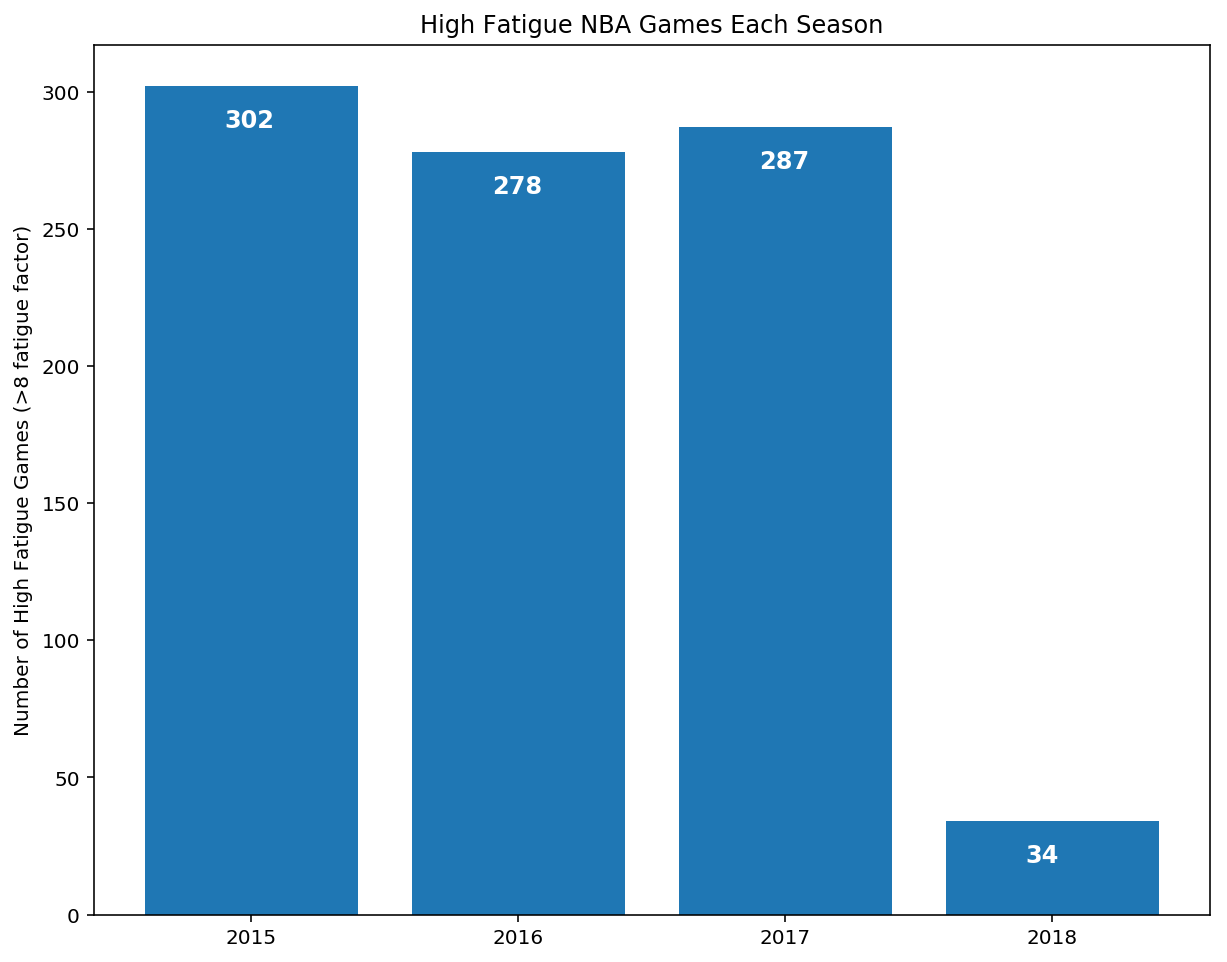

In [6]:
high_fatigue_games = []
for nba_schedule in schedules:
    nba_fatigue = pd.DataFrame([fatigue(team, nba_schedule) for team in teams])
    nba_fatigue = nba_fatigue.unstack()
    high_fatigue_games.append(nba_fatigue[nba_fatigue > 8].count())
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(years, high_fatigue_games)
ax.set(title='High Fatigue NBA Games Each Season', ylabel='Number of High Fatigue Games (>8 fatigue factor)')
for i, v in enumerate(high_fatigue_games):
    ax.text(i-0.1, v - 15, str(v), color='white', fontweight='bold', fontsize='12')

Using the newly created fatigue factor, I got a count of the number of high fatigue games in each NBA season. As you can see above, the NBA was very successful in reducing the number of high fatigue games in the 2017-18 season, down an impressive 88.15% from the previous season. Having an extra week to spread out games truly made all the difference. 

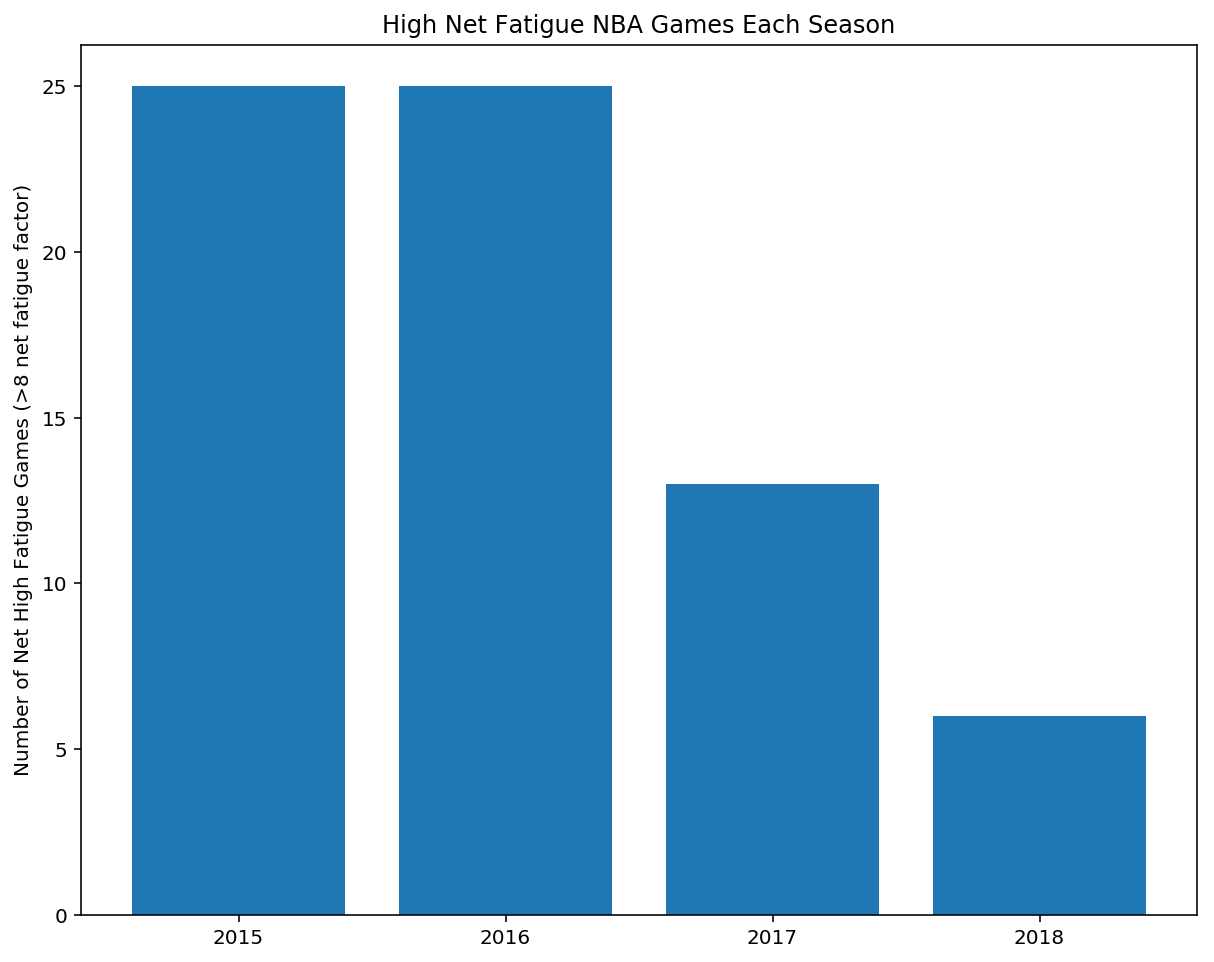

In [7]:
def add_fatigue(row, fatigue_dict):
    global first_row
    if not first_row:
        row['away_fatigue'] = fatigue_dict[row['Away']]['fatigue'][fatigue_dict[row['Away']]['game']]
        fatigue_dict[row['Away']]['game'] += 1
        row['home_fatigue'] = fatigue_dict[row['Home']]['fatigue'][fatigue_dict[row['Home']]['game']]
        fatigue_dict[row['Home']]['game'] += 1
    else:
        first_row = False
    return row

def net_fatigue(team, nba_schedule):
    team_schedule = nba_schedule[(nba_schedule['Home'] == team) | (nba_schedule['Away'] == team)]
    net_fatigue_list = []
    for row in team_schedule.iterrows():
        if row[1]['Away'] == team:
            net_fatigue = row[1]['away_fatigue'] - row[1]['home_fatigue']
        else:
            net_fatigue = row[1]['home_fatigue'] - row[1]['away_fatigue']
        net_fatigue_list.append(net_fatigue)
    return net_fatigue_list

high_net_fatigue = []
for nba_schedule in schedules:
    fatigue_dict = {}
    for team in teams:
        fatigue_dict[team] = {'game': 0, 'fatigue': fatigue(team, nba_schedule)}
    first_row = True
    nba_schedule_with_fatigue = nba_schedule.apply(add_fatigue, axis=1, fatigue_dict=fatigue_dict)
    nba_schedule_with_fatigue['net_home_fatigue'] = nba_schedule_with_fatigue['home_fatigue'] - nba_schedule_with_fatigue['away_fatigue']
    high_net_fatigue.append(nba_schedule_with_fatigue[abs(nba_schedule_with_fatigue['net_home_fatigue'] > 8)].shape[0])
    
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(years, high_net_fatigue)
ax.set(title='High Net Fatigue NBA Games Each Season', ylabel='Number of Net High Fatigue Games (>8 net fatigue factor)');

To create fairer matchups, the league also tried to reduce the number of games where one team had a rest advantage. The bar plot above shows that these games also decreased significantly, first in 2016-17 and even more the following season.

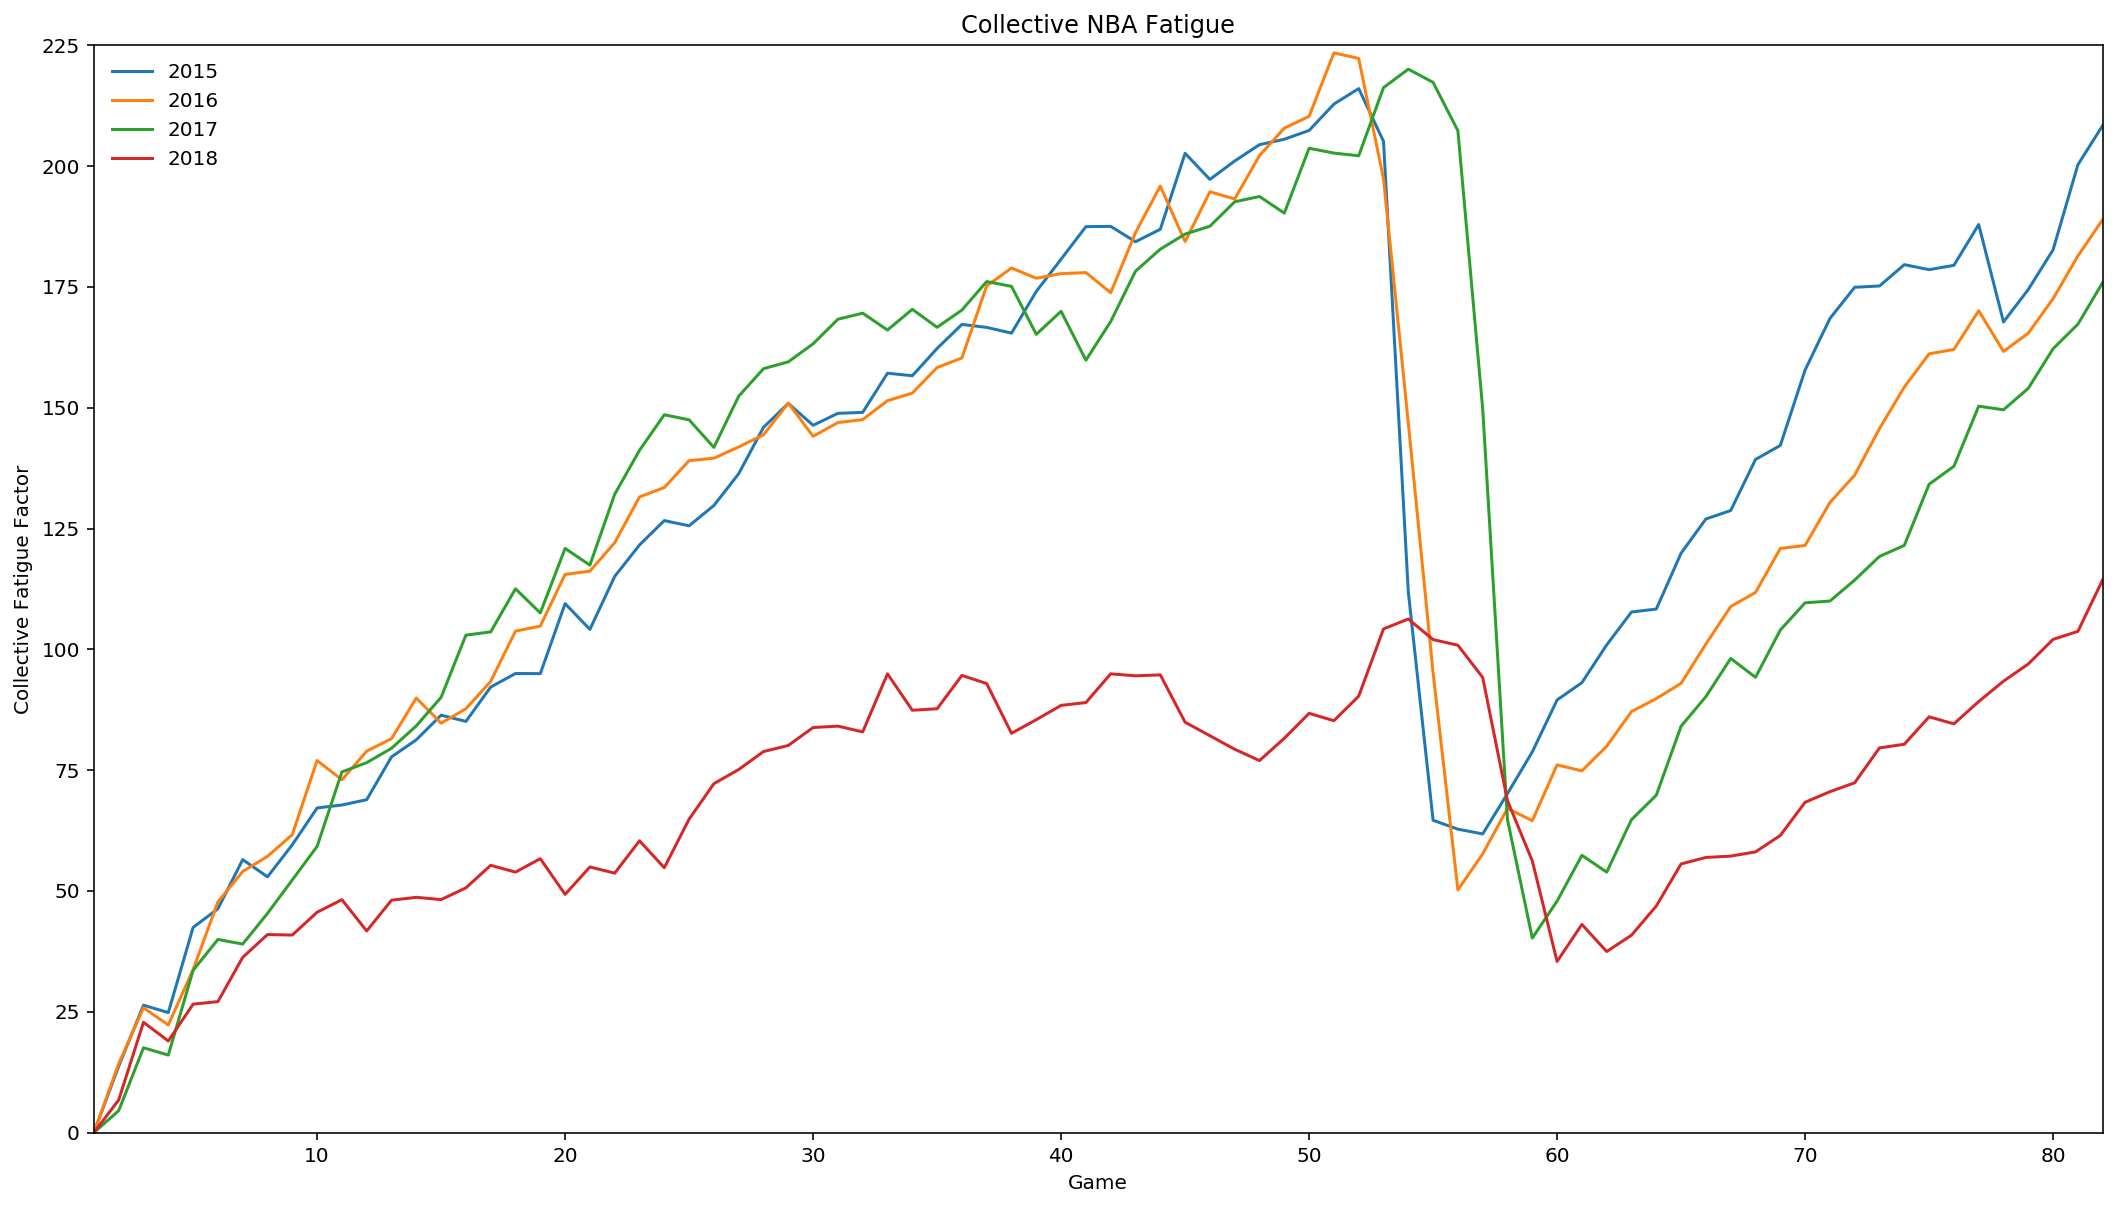

In [8]:
fig, ax = plt.subplots(figsize=(18,10))
for i, nba_schedule in enumerate(schedules):
    nba_fatigue = [fatigue(team, nba_schedule) for team in teams]
    nba_fatigue = pd.DataFrame(nba_fatigue)
    nba_fatigue = nba_fatigue.sum()
    nba_fatigue.index += 1
    ax.plot(nba_fatigue, label=years[i])
ax.set(title='Collective NBA Fatigue', ylabel='Collective Fatigue Factor', xlabel='Game', xlim=(1,82), ylim=(0,225))
ax.legend(frameon=False);

In addition to reducing high fatigue games, the league as a whole saw a significant reduction in overall fatigue in the 2017-18 season, with the collective fatigue factor never rising above 115. In previous season the collective fatigue slope was much higher, meaning there was less time for the league to rest and recover in between games.

In summary, the NBA seems to have done a great job of reducing high fatigue games, overall fatgue, back to back games and the longest road trips, but a mediocre job of reducing miles traveled and average road trip lengths.